In [2]:
### import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from pkg.utils import seir, modified_seir, run_modified_seir
from matplotlib import ticker

# Exploring Scenarios
In order to explore regimes in which the two different vaccine failure mechanisms result in a significant difference, we quantified the impact of vaccine failure using the total recovered population. For each of the three vaccination scenarios (pre-transmission, 10 days post-transmission, 30 days post-transmission), the $R_0$ values were varied from 1.0 to 3.0, vaccine efficacy was varied from 1% effective to 100% effective, and for each $R_0$ value and vaccine efficacy, we used three different vaccination population values - below, slightly above, and above the critical vaccination level. Note that the $R_0$ values used are the values before intervention.

## Critical Vaccination Threshold ($f*_V$)
The critical vaccinated threshold refers to the proportion of the population that must be vaccinated in order to reach herd immunity, preventing further transmission of the disease. This value depends on how fast the disease spreads and how effective the vaccine is, as more people would need to get vaccinated if the disease had a high $R_0$ value and low vaccine efficacy. Note that the critical vaccination level cannot exceed 1.

Recall that for this model, $R_{0,V} = R_0 (1 - \epsilon_L \epsilon_A f_V)$. From this, we can define the critical vaccination threshold as:

$$ f^*_V = \frac{1}{\epsilon_L \epsilon_A} (1 - \frac{1}{R_0}) $$

if vaccination occurs before the epidemic begins.

If vaccination occurs after the epidemic has begun, a fraction $f_R$ has already been infected are immune to reinfection. Thus, assuming an instantaneous vaccine campaign that targets only susceptible individuals,

$$ f^*_V = \frac{1}{\epsilon_L \epsilon_A} (1 - \frac{1}{R_0(1 - f_R)})$$

Furthermore, to investigate regimes where vaccination is insufficient, minimally sufficient, and exceedingly sufficient, we will compare vaccination compaigns that reach three different levels of vaccine coverage relative to $f^*_V$ as follows:

$$ f_{V, \text{below}} = 0.8f^*_V $$
$$ f_{V, \text{slightly above}} =  1 - 0.8(1 - f^*_V) $$
$$ f_{V, \text{above}} = 1 - 0.5(1 - f^*_V) $$

We then calculated the percentage reduction of the total recovered population compared to that of without vaccination by 

$$ P = \frac{R - R_V}{R} \times 100 \, (\%)$$

where $R$ is the normalized total recovered population without vaccination and $R_V$ is the normalized total recovered population with vaccination through a 'leaky' or 'all-or-nothing' vaccine.

We then found the difference in percentage reduction between the two vaccine failure mechanisms by subtracting $P_L$ from $P_A$ because the 'all-or-nothing' vaccine always performed better than the 'leaky' vaccine.

The simulation was run for 15,000 days, with the following parameter values and initial conditions: $\gamma = 1/4$, $\sigma=1/4$, $S(0) = 0.98$, $E(0) = 0.01$, $I(0) = 0.01$, $R(0) = 0$. 

## Pre-transmission Vaccination

In [13]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; 
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
t= np.linspace(0, 15000, 15001); tv = -1

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_fvs = []; df_covs = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    for eps in epss:
        fc = 1/eps * (1 - 1/R0)
        for cov in covs:
            if cov == 'Below fc':
                fv = fc * 0.8
            elif cov == 'Slightly Above fc':
                fv = 1 - ((1 - fc) * 0.8)
            else:
                fv = 1 - ((1 - fc) * 0.5)

            s0_vax = 0.98-fv 
            
            # leaky
            vs0_leaky = 0; vr0_leaky = fv; y0_leaky = [s0_vax, vs0_leaky, vr0_leaky, e0, i0, r0]
            sim_leaky = run_modified_seir(y0_leaky, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')
            _, _, _, _, _, _, r_leaky = sim_leaky

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = r_tot - r_tot_leaky / r_tot * 100

            # aon
            vs0_aon = fv*(1-eps); vr0_aon = fv*eps; y0_aon = [s0_vax, vs0_aon, vr0_aon, e0, i0, r0]
            sim_aon = run_modified_seir(y0_aon, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
            _, _, _, _, _, _, r_aon = sim_aon

            r_tot_aon = r_aon[-1]
            r_perc_aon = r_tot - r_tot_aon / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky

            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_fvs.append(fv)
            df_covs.append(cov)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Pre' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
    'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
pre_df = pd.DataFrame(data=data)

pre_df.head()

below_pre_df = pre_df[pre_df['Vax Coverage'] == 'Below fc']
slabove_pre_df = pre_df[pre_df['Vax Coverage'] == 'Slightly Above fc']
above_pre_df = pre_df[pre_df['Vax Coverage'] == 'Above fc']

# reshape data for plotting
pre_plot_R0, pre_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
pre_plot_diff_below = np.nan_to_num(np.reshape(below_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_above = np.nan_to_num(np.reshape(above_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))

## 10 Days Post-Transmission Vaccination

In [16]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, 15000, 15001); tv = 10

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_fvs = []; df_covs = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    _, _, _, r = sim.T
    
    r_tot = r[-1]

    # find fr
    sim = odeint(seir, y0, np.linspace(0, tv, tv+1), args=(beta, sigma, gamma))
    s, _, _, _ = sim.T
    fr = 1 - s[-1]

    for eps in epss:
        fc = 1/eps * (1 - (1 - fr)/R0)
        for cov in covs:
            if cov == 'Below fc':
                fv = fc * 0.8
            elif cov == 'Slightly Above fc':
                fv = 1 - ((1 - fc) * 0.8)
            else:
                fv = 1 - ((1 - fc) * 0.5)

            # leaky
            sim_leaky = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')
            _, _, _, _, _, _, r_leaky = sim_leaky

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = r_tot - r_tot_leaky / r_tot * 100

            # aon
            sim_aon = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
            _, _, _, _, _, _, r_aon = sim_aon
            
            r_tot_aon = r_aon[-1]
            r_perc_aon = r_tot - r_tot_aon / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_fvs.append(fv)
            df_covs.append(cov)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Post 10' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
    'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post10_df = pd.DataFrame(data=data)

post10_df.head()

below_post10_df = post10_df[post10_df['Vax Coverage'] == 'Below fc']
slabove_post10_df = post10_df[post10_df['Vax Coverage'] == 'Slightly Above fc']
above_post10_df = post10_df[post10_df['Vax Coverage'] == 'Above fc']

# reshape data for plotting
post10_plot_R0, post10_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post10_plot_diff_below = np.nan_to_num(np.reshape(below_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_above = np.nan_to_num(np.reshape(above_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))

## 30 Days Post-Transmission Vaccination

In [17]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, 15000, 15001); tv = 30

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_fvs = []; df_covs = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    _, _, _, r= sim.T
    
    r_tot = r[-1]

    # find fr
    sim = odeint(seir, y0, np.linspace(0, tv, tv+1), args=(beta, sigma, gamma))
    s, _, _, _ = sim.T
    fr = 1 - s[-1]

    for eps in epss:
        fc = 1/eps * (1 - (1 - fr)/R0)
        for cov in covs:
            if cov == 'Below fc':
                fv = fc * 0.8
            elif cov == 'Slightly Above fc':
                fv = 1 - ((1 - fc) * 0.8)
            else:
                fv = 1 - ((1 - fc) * 0.5)

            # leaky
            sim_leaky = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')
            _, _, _, _, _, _, r_leaky = sim_leaky

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = r_tot - r_tot_leaky / r_tot * 100

            # aon
            sim_aon = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
            _, _, _, _, _, _, r_aon = sim_aon
            
            r_tot_aon = r_aon[-1]
            r_perc_aon = r_tot - r_tot_aon / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_fvs.append(fv)
            df_covs.append(cov)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build data frame                      
df_timings = ['Post 30' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
    'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post30_df = pd.DataFrame(data=data)

below_post30_df = post30_df[post30_df['Vax Coverage'] == 'Below fc']
slabove_post30_df = post30_df[post30_df['Vax Coverage'] == 'Slightly Above fc']
above_post30_df = post30_df[post30_df['Vax Coverage'] == 'Above fc']

# reshape data for plotting
post30_plot_R0, post30_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post30_plot_diff_below = np.nan_to_num(np.reshape(below_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_above = np.nan_to_num(np.reshape(above_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))

## Results

Based on the values obtained from above, we plotted the absolute value of the difference between the two vaccine failure mechanisms in the percentage reduction of the total recovered population. Note that the values were plotted based on a log-scale, but the colorbar on the right of each plot is labelled based on the actual values. 

### 3D Surface Plot

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_34281/1179020255.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


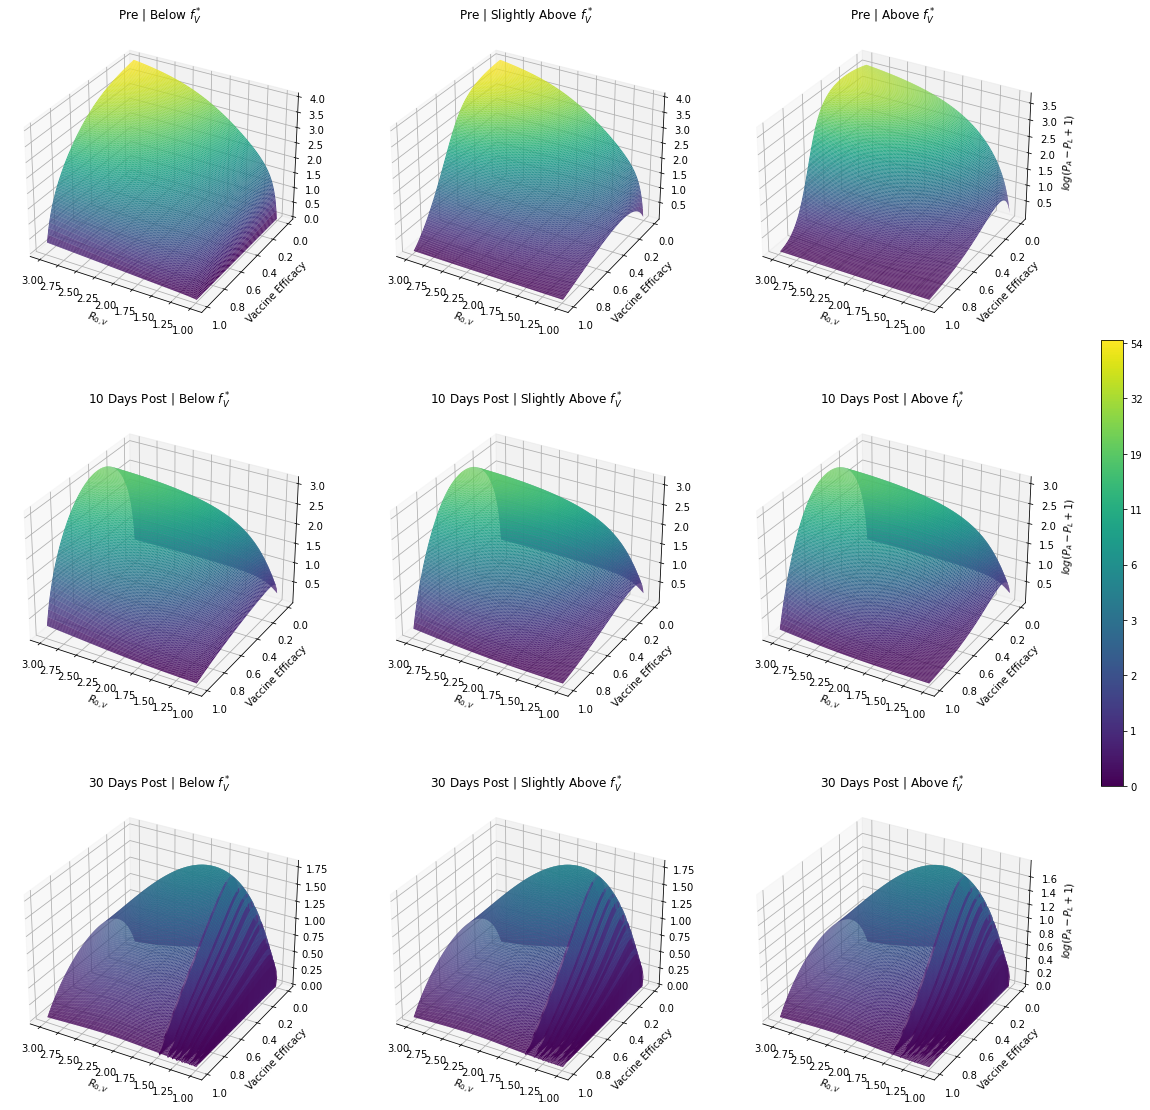

In [18]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(20,20), gridspec_kw=dict(width_ratios=[1,1,1]), subplot_kw={'projection': '3d'})
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission
surf1 = axes[0,0].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), rstride=1, norm=norm, cstride=1, cmap='viridis')
axes[0,0].set_title('Pre | Below $f^*_V$')

axes[0,1].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above $f^*_V$')

axes[0,2].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[0,2].set_title('Pre | Above $f^*_V$')
axes[0,2].set_zlabel('$log(P_A - P_L + 1)$')


# 10 days post-tranmission
axes[1,0].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below $f^*_V$')

axes[1,1].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above $f^*_V$')

axes[1,2].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above $f^*_V$')
axes[1,2].set_zlabel('$log(P_A - P_L + 1)$')

# 30 days post-transmission
axes[2,0].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below $f^*_V$')

axes[2,1].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above $f^*_V$')

axes[2,2].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above $f^*_V$')
axes[2,2].set_zlabel('$log(P_A - P_L + 1)$')

axs = np.array(axes)
for ax in axs.reshape(-1):
    ax.set_xlabel('$R_{0,V}$')
    ax.set_ylabel('Vaccine Efficacy')
    ax.view_init(elev=30, azim=120)

#fig.tight_layout(pad=0.1)
cb = fig.colorbar(mappable=surf1, ax=axes, fraction=0.02, shrink=0.5)
cblabels = np.interp(cb.ax.get_yticks(), cb.ax.get_ylim(), surf1.get_clim())
cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))
#plt.savefig('VE vs R0 Surface Plot', bbox_inches='tight')
plt.show()

### 2D Contour Plot

This plot is the 2D projection of the 3D surface plot above.

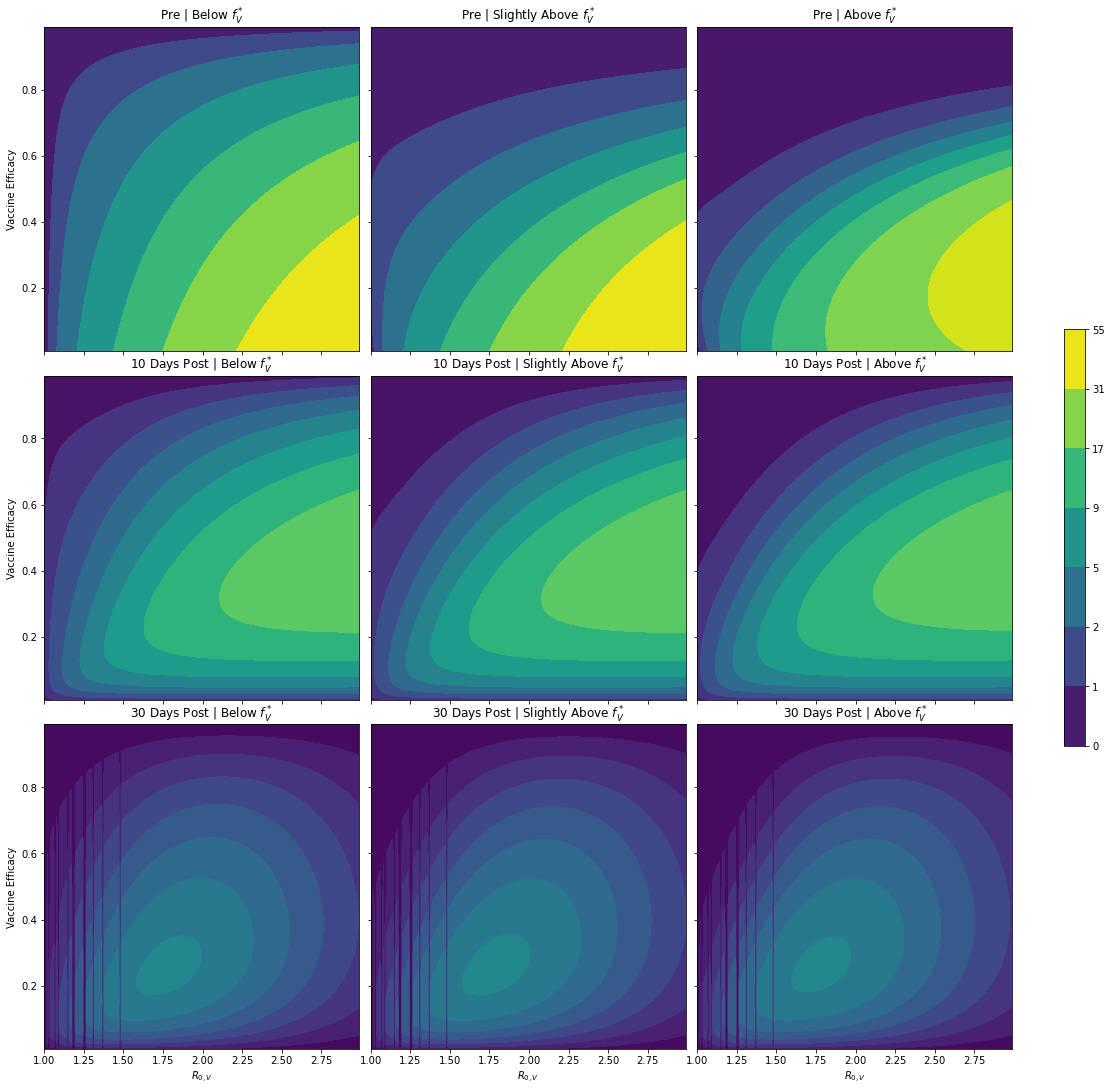

In [19]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), sharex=True, sharey=True, gridspec_kw=dict(width_ratios=[1,1,1]))
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission 
proj = axes[0,0].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), norm=norm, cmap='viridis')
axes[0,0].set_title('Pre | Below $f^*_V$')
axes[0,0].set_ylabel('Vaccine Efficacy')

axes[0,1].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above $f^*_V$')

#ax3 = fig.add_subplot(133)
axes[0,2].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), norm=norm, cmap='viridis')
axes[0,2].set_title('Pre | Above $f^*_V$')

# 10 days post-transmission
axes[1,0].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), norm=norm, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below $f^*_V$')
axes[1,0].set_ylabel('Vaccine Efficacy')

axes[1,1].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above $f^*_V$')

axes[1,2].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), norm=norm, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above $f^*_V$')

# 30 days post-transmission
axes[2,0].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), norm=norm, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below $f^*_V$')
axes[2,0].set_ylabel('Vaccine Efficacy')
axes[2,0].set_xlabel('$R_{0,V}$')

axes[2,1].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above $f^*_V$')
axes[2,1].set_xlabel('$R_{0,V}$')

axes[2,2].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), norm=norm, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above $f^*_V$')
axes[2,2].set_xlabel('$R_{0,V}$')

fig.tight_layout(pad=0.1)
cb = fig.colorbar(mappable=proj, ax=axes, fraction=0.02, shrink=0.5)
cblabels = np.interp(cb.ax.get_yticks(), cb.ax.get_ylim(), surf1.get_clim())
cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))
#plt.savefig('VE vs R0 2D Contour Plot', bbox_inches='tight')
plt.show()

Next, instead of finding the difference in recovered population at the end of the pandemic, let's find the difference in recovered population 60 days after vaccination.

## Pre-Transmisson Vacciation


In [3]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; 
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
t= np.linspace(0, 60, 61); tv = -1

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_fvs = []; df_covs = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    for eps in epss:
        fc = 1/eps * (1 - 1/R0)
        for cov in covs:
            if cov == 'Below fc':
                fv = fc * 0.8
            elif cov == 'Slightly Above fc':
                fv = 1 - ((1 - fc) * 0.8)
            else:
                fv = 1 - ((1 - fc) * 0.5)

            s0_vax = 0.98-fv 
            
            # leaky
            vs0_leaky = 0; vr0_leaky = fv; y0_leaky = [s0_vax, vs0_leaky, vr0_leaky, e0, i0, r0]
            sim_leaky = run_modified_seir(y0_leaky, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')
            _, _, _, _, _, _, r_leaky = sim_leaky

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = r_tot - r_tot_leaky / r_tot * 100

            # aon
            vs0_aon = fv*(1-eps); vr0_aon = fv*eps; y0_aon = [s0_vax, vs0_aon, vr0_aon, e0, i0, r0]
            sim_aon = run_modified_seir(y0_aon, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
            _, _, _, _, _, _, r_aon = sim_aon

            r_tot_aon = r_aon[-1]
            r_perc_aon = r_tot - r_tot_aon / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky

            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_fvs.append(fv)
            df_covs.append(cov)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Pre' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
    'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
pre_df = pd.DataFrame(data=data)

pre_df.head()

below_pre_df = pre_df[pre_df['Vax Coverage'] == 'Below fc']
slabove_pre_df = pre_df[pre_df['Vax Coverage'] == 'Slightly Above fc']
above_pre_df = pre_df[pre_df['Vax Coverage'] == 'Above fc']

# reshape data for plotting
pre_plot_R0, pre_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
pre_plot_diff_below = np.nan_to_num(np.reshape(below_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_above = np.nan_to_num(np.reshape(above_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))

## 10 Days Post-Transmission Vaccination

In [4]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, tv+60, tv+61); tv = 10

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_fvs = []; df_covs = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    _, _, _, r = sim.T
    
    r_tot = r[-1]

    # find fr
    sim = odeint(seir, y0, np.linspace(0, tv, tv+1), args=(beta, sigma, gamma))
    s, _, _, _ = sim.T
    fr = 1 - s[-1]

    for eps in epss:
        fc = 1/eps * (1 - (1 - fr)/R0)
        for cov in covs:
            if cov == 'Below fc':
                fv = fc * 0.8
            elif cov == 'Slightly Above fc':
                fv = 1 - ((1 - fc) * 0.8)
            else:
                fv = 1 - ((1 - fc) * 0.5)

            # leaky
            sim_leaky = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')
            _, _, _, _, _, _, r_leaky = sim_leaky

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = r_tot - r_tot_leaky / r_tot * 100

            # aon
            sim_aon = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
            _, _, _, _, _, _, r_aon = sim_aon
            
            r_tot_aon = r_aon[-1]
            r_perc_aon = r_tot - r_tot_aon / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_fvs.append(fv)
            df_covs.append(cov)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Post 10' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
    'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post10_df = pd.DataFrame(data=data)

post10_df.head()

below_post10_df = post10_df[post10_df['Vax Coverage'] == 'Below fc']
slabove_post10_df = post10_df[post10_df['Vax Coverage'] == 'Slightly Above fc']
above_post10_df = post10_df[post10_df['Vax Coverage'] == 'Above fc']

# reshape data for plotting
post10_plot_R0, post10_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post10_plot_diff_below = np.nan_to_num(np.reshape(below_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_above = np.nan_to_num(np.reshape(above_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))

## 30 Days Post-Transmission Vaccination

In [5]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, tv+60, tv+61); tv = 30

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_fvs = []; df_covs = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    _, _, _, r= sim.T
    
    r_tot = r[-1]

    # find fr
    sim = odeint(seir, y0, np.linspace(0, tv, tv+1), args=(beta, sigma, gamma))
    s, _, _, _ = sim.T
    fr = 1 - s[-1]

    for eps in epss:
        fc = 1/eps * (1 - (1 - fr)/R0)
        for cov in covs:
            if cov == 'Below fc':
                fv = fc * 0.8
            elif cov == 'Slightly Above fc':
                fv = 1 - ((1 - fc) * 0.8)
            else:
                fv = 1 - ((1 - fc) * 0.5)

            # leaky
            sim_leaky = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')
            _, _, _, _, _, _, r_leaky = sim_leaky

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = r_tot - r_tot_leaky / r_tot * 100

            # aon
            sim_aon = run_modified_seir(y0_vax, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')
            _, _, _, _, _, _, r_aon = sim_aon
            
            r_tot_aon = r_aon[-1]
            r_perc_aon = r_tot - r_tot_aon / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_fvs.append(fv)
            df_covs.append(cov)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build data frame                      
df_timings = ['Post 30' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
    'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post30_df = pd.DataFrame(data=data)

below_post30_df = post30_df[post30_df['Vax Coverage'] == 'Below fc']
slabove_post30_df = post30_df[post30_df['Vax Coverage'] == 'Slightly Above fc']
above_post30_df = post30_df[post30_df['Vax Coverage'] == 'Above fc']

# reshape data for plotting
post30_plot_R0, post30_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post30_plot_diff_below = np.nan_to_num(np.reshape(below_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_above = np.nan_to_num(np.reshape(above_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))

## Results
### 3D Contour Plot

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_69926/1179020255.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


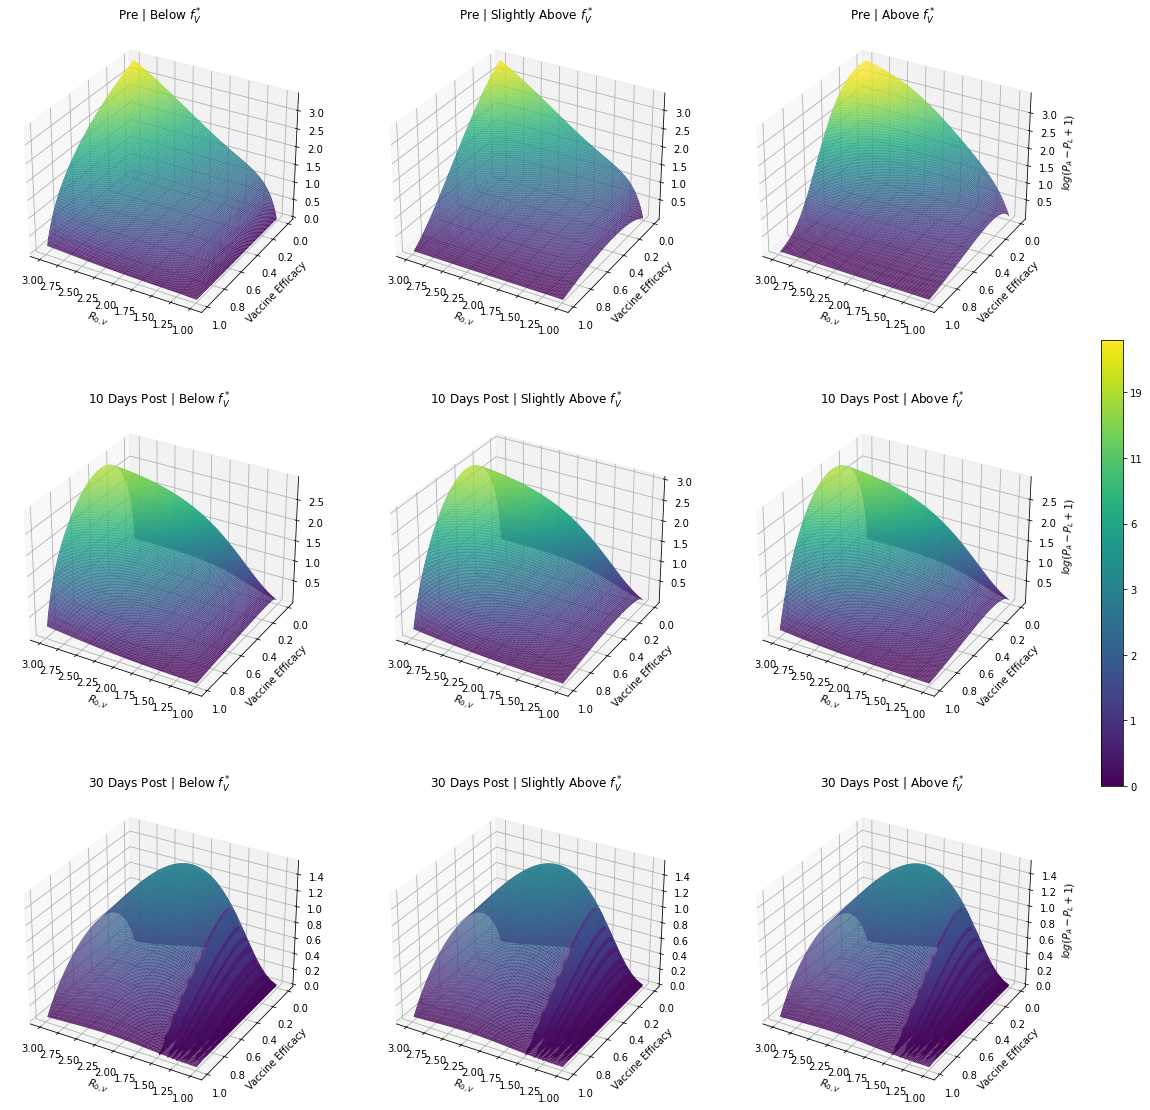

In [6]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(20,20), gridspec_kw=dict(width_ratios=[1,1,1]), subplot_kw={'projection': '3d'})
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission
surf1 = axes[0,0].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), rstride=1, norm=norm, cstride=1, cmap='viridis')
axes[0,0].set_title('Pre | Below $f^*_V$')

axes[0,1].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above $f^*_V$')

axes[0,2].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[0,2].set_title('Pre | Above $f^*_V$')
axes[0,2].set_zlabel('$log(P_A - P_L + 1)$')


# 10 days post-tranmission
axes[1,0].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below $f^*_V$')

axes[1,1].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above $f^*_V$')

axes[1,2].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above $f^*_V$')
axes[1,2].set_zlabel('$log(P_A - P_L + 1)$')

# 30 days post-transmission
axes[2,0].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below $f^*_V$')

axes[2,1].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above $f^*_V$')

axes[2,2].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above $f^*_V$')
axes[2,2].set_zlabel('$log(P_A - P_L + 1)$')

axs = np.array(axes)
for ax in axs.reshape(-1):
    ax.set_xlabel('$R_{0,V}$')
    ax.set_ylabel('Vaccine Efficacy')
    ax.view_init(elev=30, azim=120)

#fig.tight_layout(pad=0.1)
cb = fig.colorbar(mappable=surf1, ax=axes, fraction=0.02, shrink=0.5)
cblabels = np.interp(cb.ax.get_yticks(), cb.ax.get_ylim(), surf1.get_clim())
cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))
#plt.savefig('VE vs R0 Surface Plot', bbox_inches='tight')
plt.show()

### 2D Contour Plot

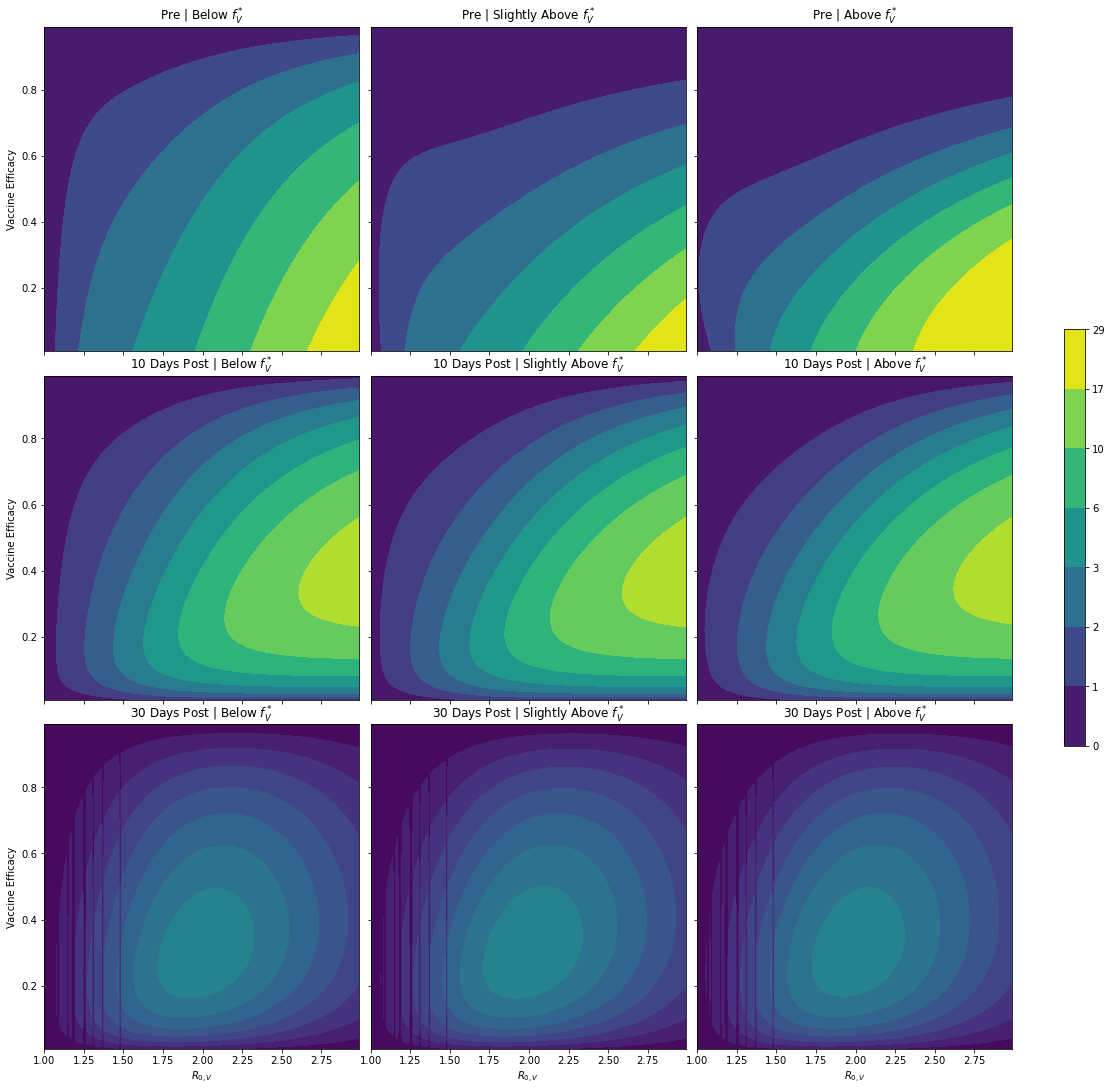

In [7]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), sharex=True, sharey=True, gridspec_kw=dict(width_ratios=[1,1,1]))
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission 
proj = axes[0,0].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), norm=norm, cmap='viridis')
axes[0,0].set_title('Pre | Below $f^*_V$')
axes[0,0].set_ylabel('Vaccine Efficacy')

axes[0,1].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above $f^*_V$')

#ax3 = fig.add_subplot(133)
axes[0,2].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), norm=norm, cmap='viridis')
axes[0,2].set_title('Pre | Above $f^*_V$')

# 10 days post-transmission
axes[1,0].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), norm=norm, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below $f^*_V$')
axes[1,0].set_ylabel('Vaccine Efficacy')

axes[1,1].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above $f^*_V$')

axes[1,2].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), norm=norm, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above $f^*_V$')

# 30 days post-transmission
axes[2,0].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), norm=norm, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below $f^*_V$')
axes[2,0].set_ylabel('Vaccine Efficacy')
axes[2,0].set_xlabel('$R_{0,V}$')

axes[2,1].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above $f^*_V$')
axes[2,1].set_xlabel('$R_{0,V}$')

axes[2,2].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), norm=norm, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above $f^*_V$')
axes[2,2].set_xlabel('$R_{0,V}$')

fig.tight_layout(pad=0.1)
cb = fig.colorbar(mappable=proj, ax=axes, fraction=0.02, shrink=0.5)
cblabels = np.interp(cb.ax.get_yticks(), cb.ax.get_ylim(), surf1.get_clim())
cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))
#plt.savefig('VE vs R0 2D Contour Plot', bbox_inches='tight')
plt.show()